In [191]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage import draw
import csv


In [192]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Sat, 25 Mar 2023 11:19:10] [INFO    ] [topostats] Extracting image from PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm
[Sat, 25 Mar 2023 11:19:10] [INFO    ] [topostats] Loading image from : PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm
[Sat, 25 Mar 2023 11:19:12] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006] : Loaded image from : PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm
[Sat, 25 Mar 2023 11:19:12] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006] : Extracted channel Height
[Sat, 25 Mar 2023 11:19:12] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006] : Pixel to nm scaling : 2.1866406250000003


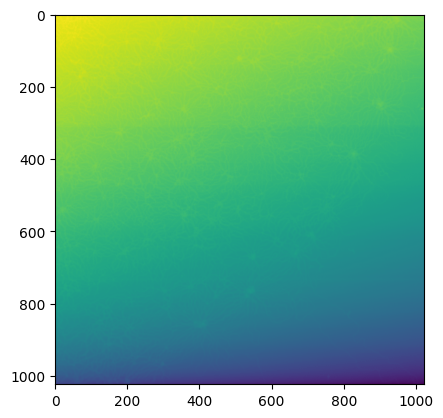

In [193]:
    #Zoom
file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [194]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Sat, 25 Mar 2023 11:19:14] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : Median flattening without mask
[Sat, 25 Mar 2023 11:19:14] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : Plane tilt removal without mask
[Sat, 25 Mar 2023 11:19:14] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : x-polyfit 1st order: [-0.01373336  6.99787912]
[Sat, 25 Mar 2023 11:19:14] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : y-polyfit 1st order: [-8.02035087e-20  1.79801973e-16]
[Sat, 25 Mar 2023 11:19:14] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : Removing x plane tilt
[Sat, 25 Mar 2023 11:19:16] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm] : removing y plane tilt
[Sat, 25 Mar 2023 11:19:17] [INFO    ] [topostats] [PristineZoom\20230126_KPN005_25mMMgCl2_Vac_24hr.0

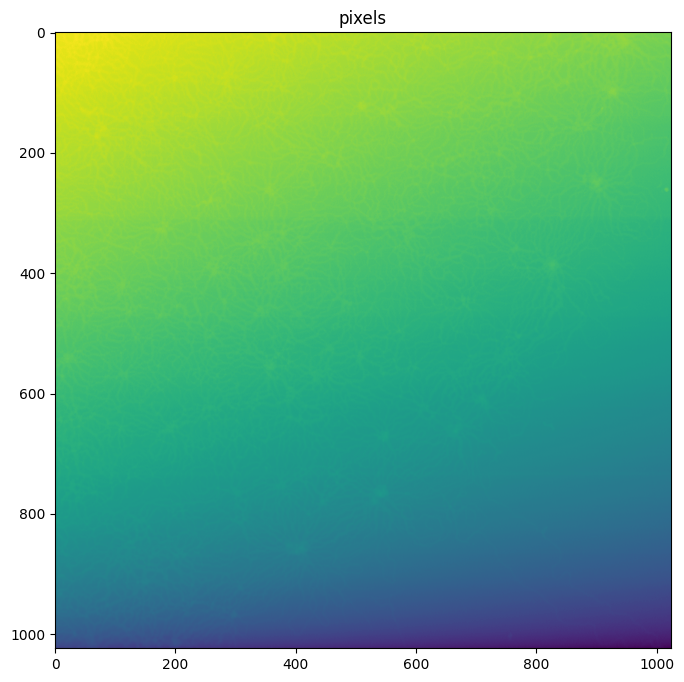

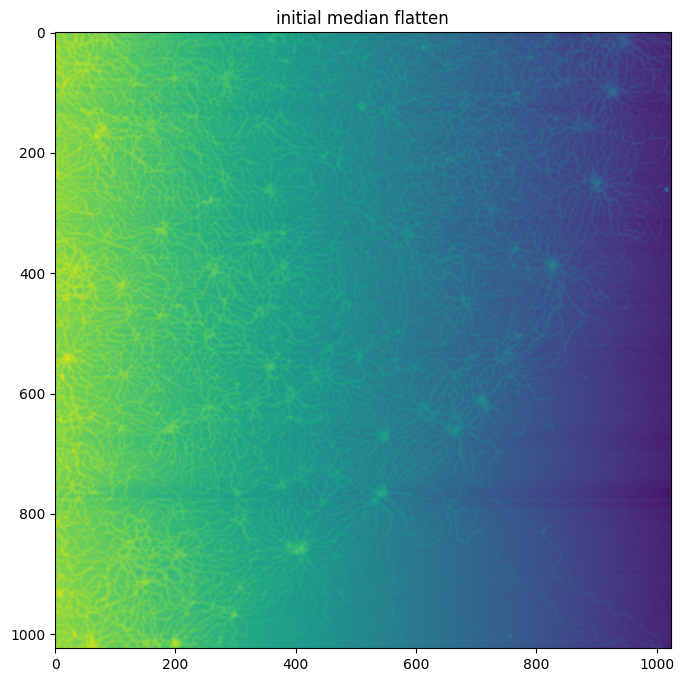

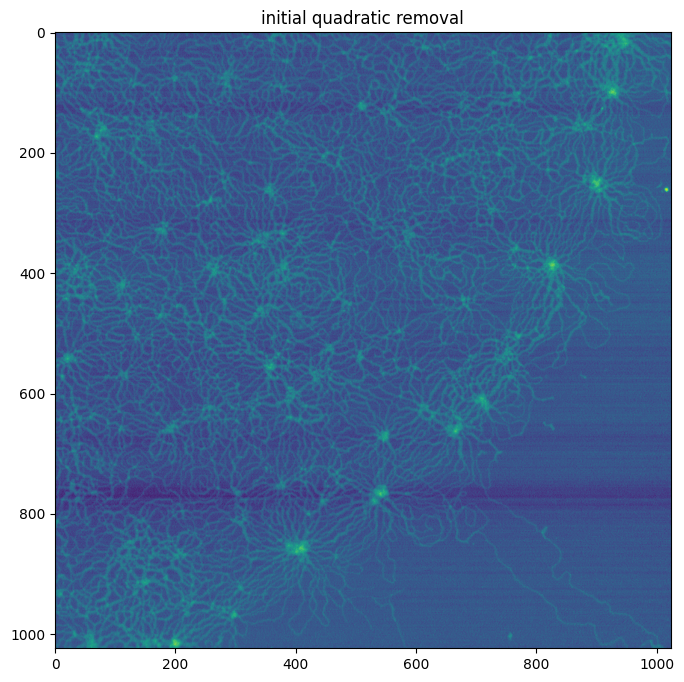

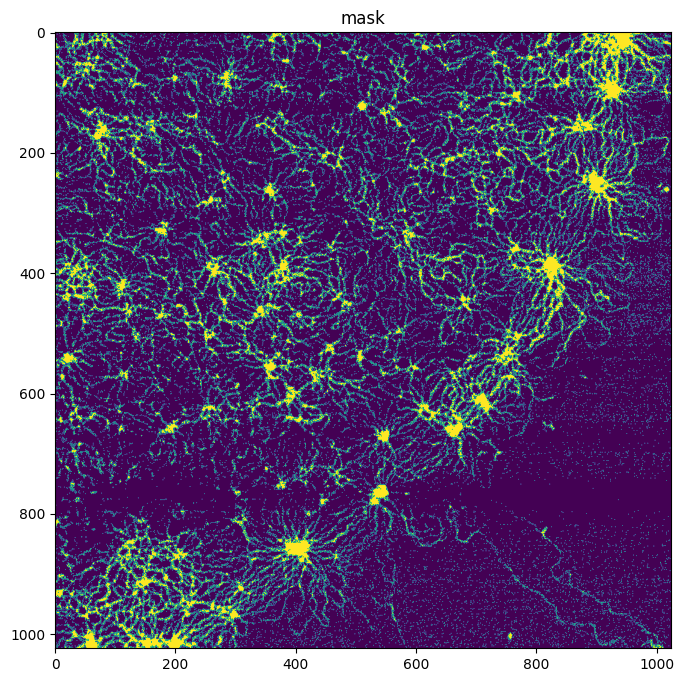

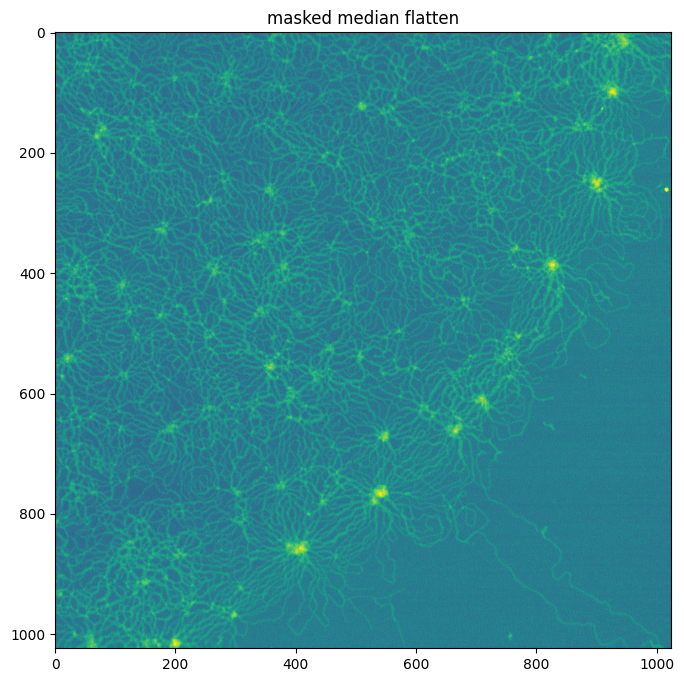

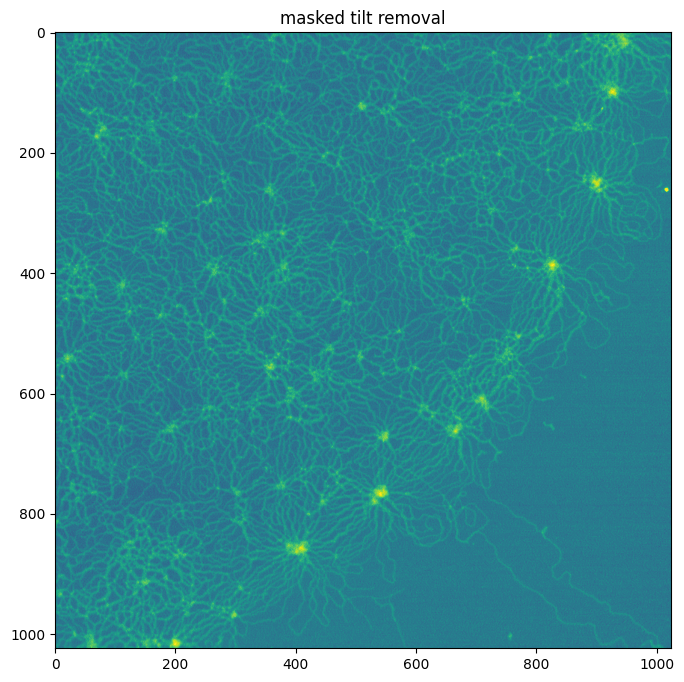

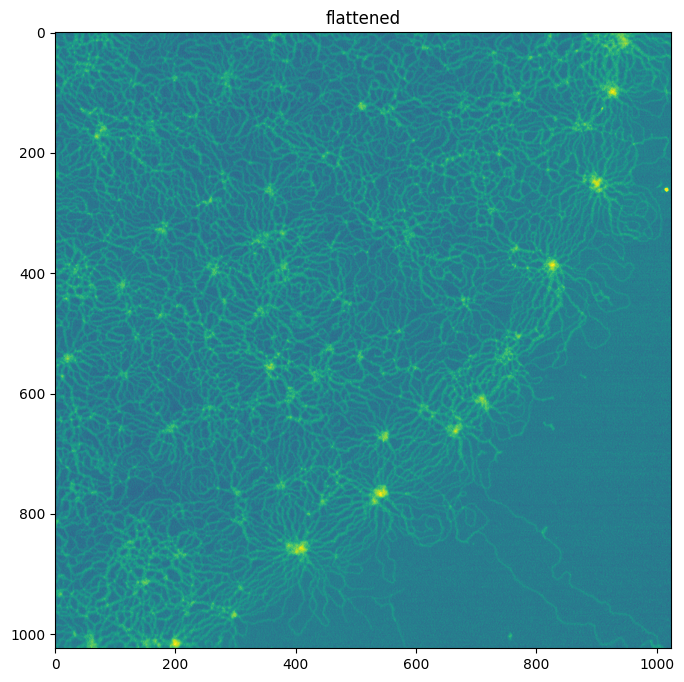

In [195]:
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 1.9040754723341191})
[Sat, 25 Mar 2023 11:20:12] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.9040754723341191


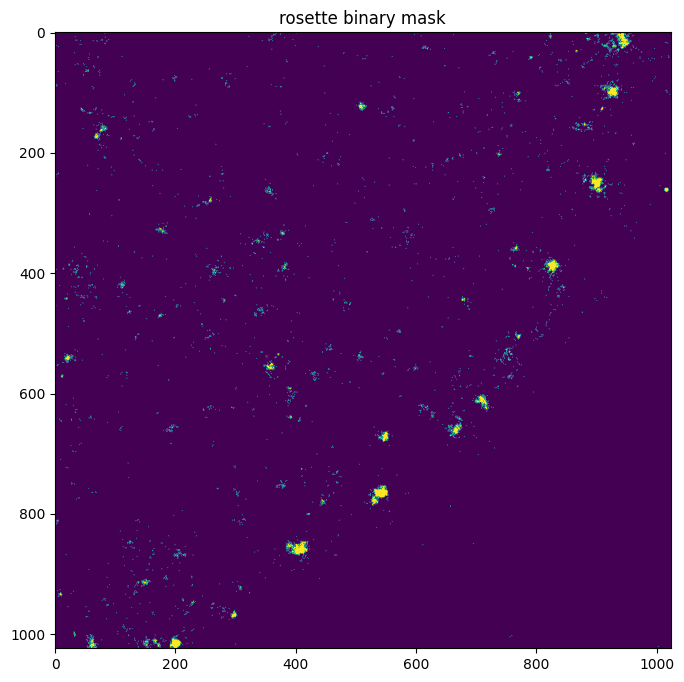

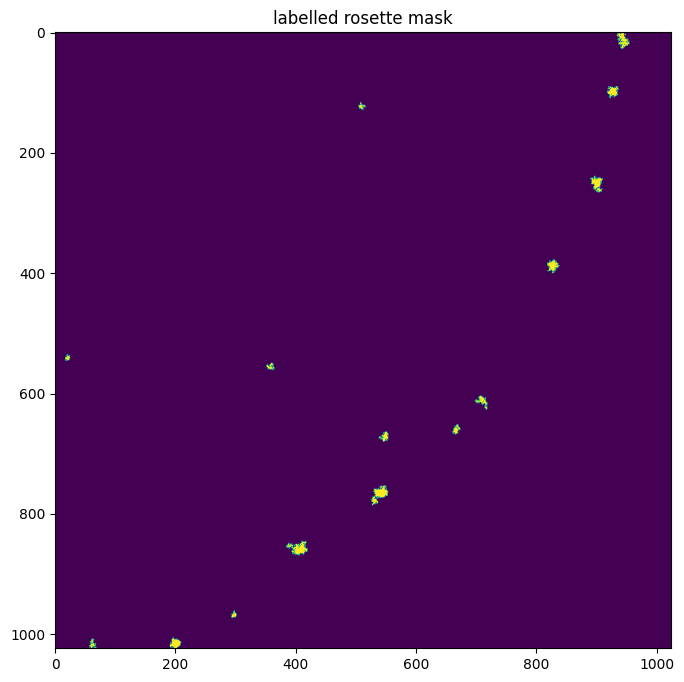

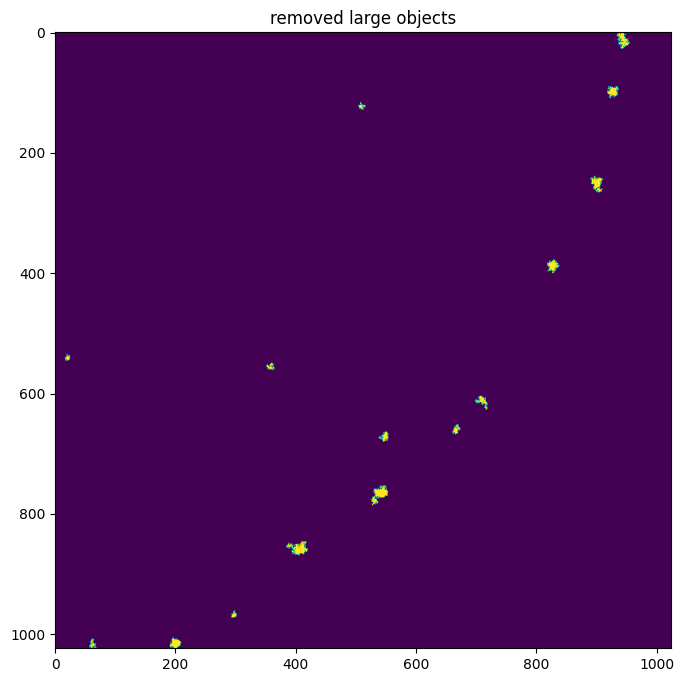

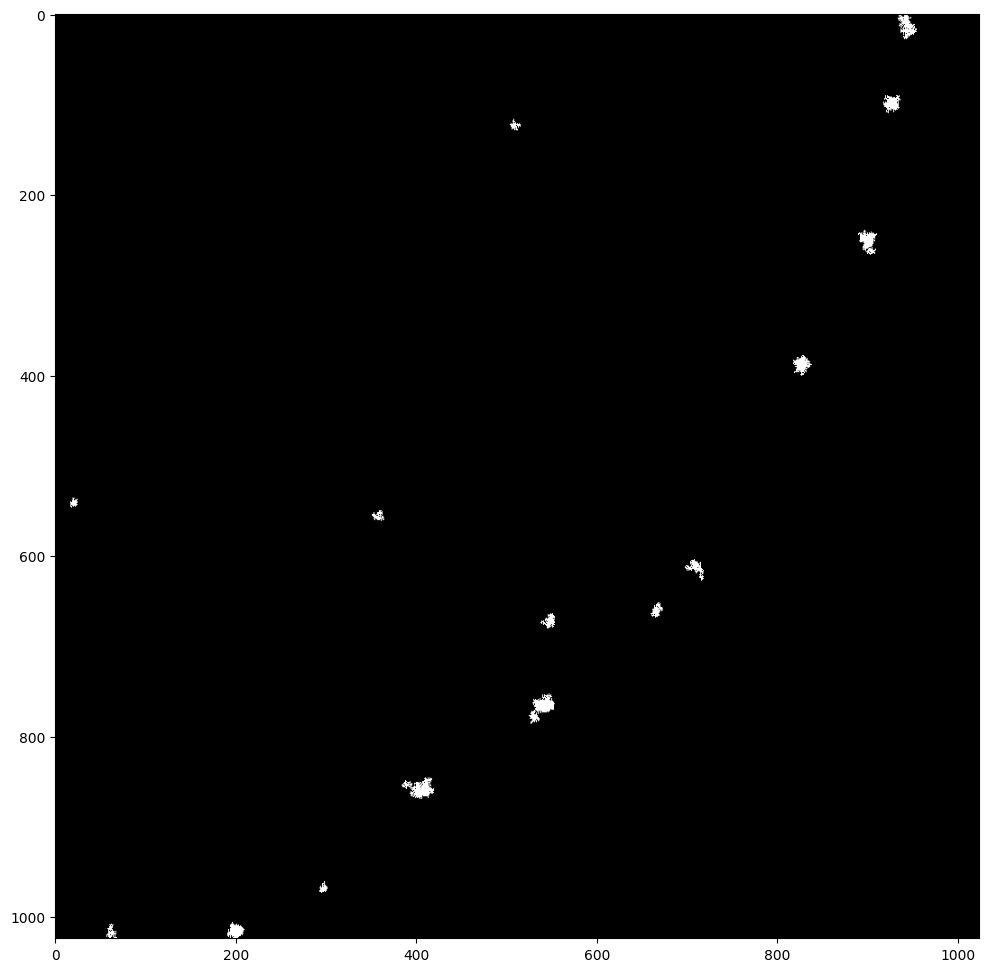

In [196]:
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 3, 'lower': None}
)
# rosette_thresholds = topofilters.get_thresholds(
#     flattened,
#     threshold_method='absolute',
#     threshold_absolute={'upper': 3.75, 'lower': None}
# )
print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 50)
# plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


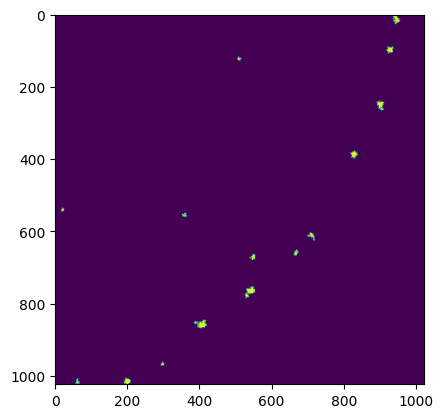

In [182]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()

node_points = labelled_rosette_mask.copy()

# Find centroids of remaining points
labelled = label(node_points)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    print(props_index,props.centroid[0])
    points[props_index, :] = (props.centroid[0],props.centroid[1])

#centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)



print(points)

#for point

Out of bounds
Area: 507.6666936525148
Area: 299.57448800427323
Area: 559.9084601244413
Area: 625.3061952061382
Out of bounds
Area: 373.6725097688475
Area: 475.61607331999767
Area: 479.6850488642974
Area: 311.3236211195672
Area: 398.12630286501167
Area: 510.30046538456736
Area: 491.9148046118991
Out of bounds
Out of bounds


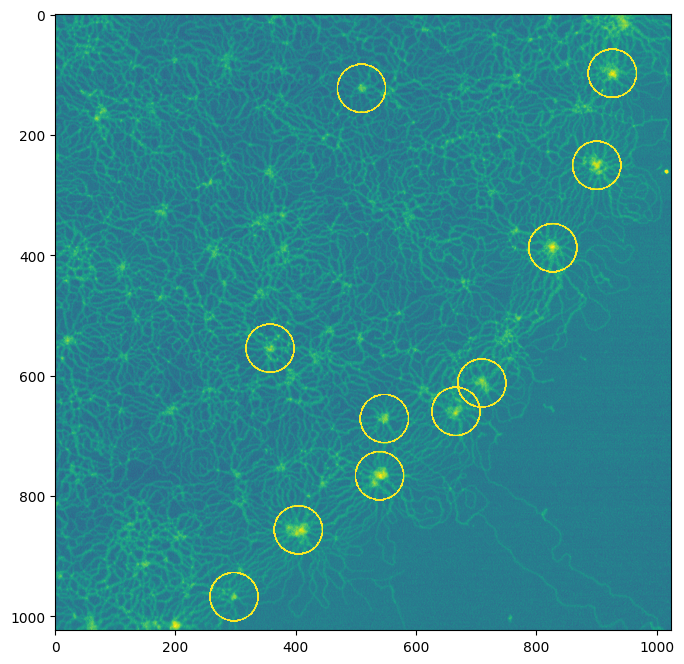

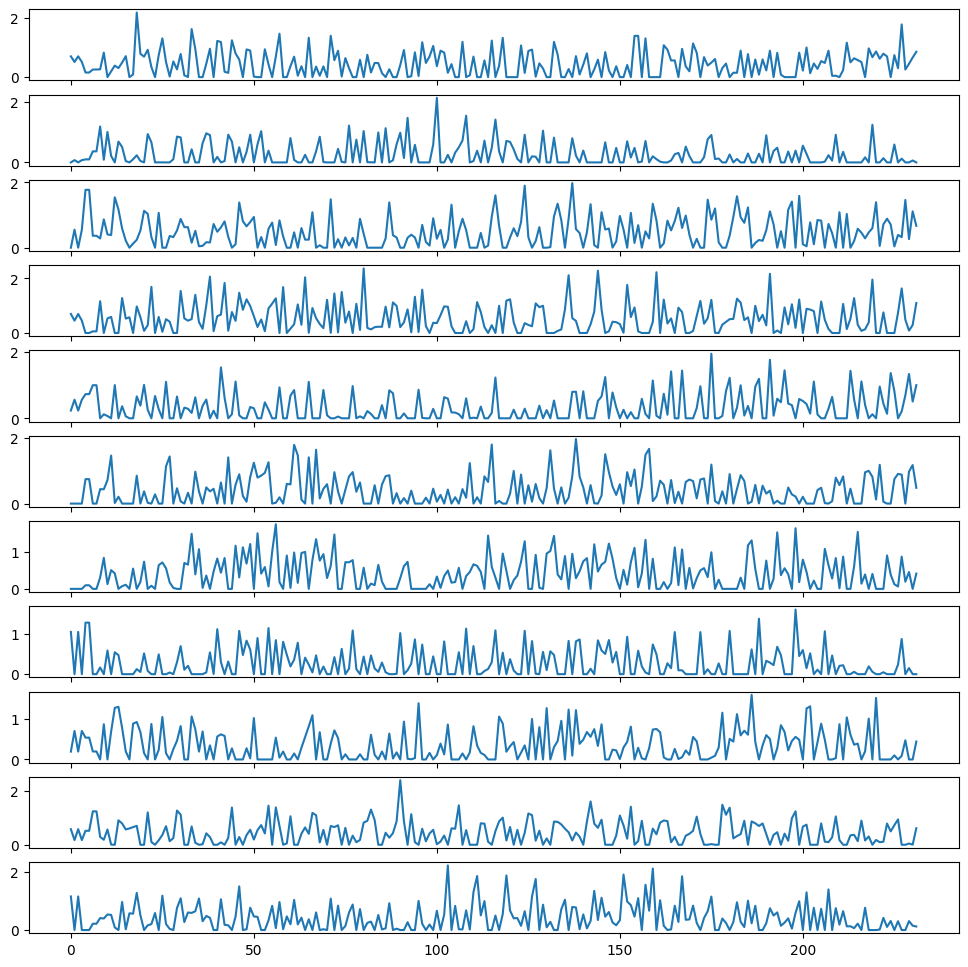

In [255]:
#Create circular masks around each nodes and extract heights
circle_mask = flattened.copy()
circle_image = flattened.copy()
radius =  40
region_values = []
included = []
area_tot = []
for point in points:
    rr,cc = draw.circle_perimeter(int(point[0]), int(point[1]), radius, method='bresenham')
    if any((i<0 or i>1024) for i in rr) or any((j<0 or j>1024) for j in cc):
        print("Out of bounds")
    else:  
        #sets all values <0 to 0
        perimeter_values = np.clip(circle_mask[rr,cc],0,1000)
        region_values.append(perimeter_values)
        circle_image[rr,cc] = 100
        included = np.append(included,point)
        #print(point[0],point[1])
        area_tot = np.trapz(perimeter_values,dx=5)
        print("Area:",area_tot)
        #plt.text(point[0],point[1],"1",fontsize=1)


plot(circle_image)
plt.show()
fig, ax = plt.subplots(len(region_values),1,figsize=(12, 12), sharex=True)
for i, values in enumerate(region_values):
    ax[i].plot(values)


In [16]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

In [17]:
def point_distances(points: np.ndarray):
    distance_matrix = distance.cdist(points, points, 'euclidean')
    distances = distance_matrix[np.triu_indices(points.shape[0], k=1)]
    return np.round(distances, 5)

In [18]:
def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [207]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume

    return {
        'areas': areas,
        'volumes': volumes,
        'number_of_regions': len(region_props)
    }

number of nodes in perimeter: 65
total object area: 46.8365549657294 μm^2
perimeter: 25.23495694077266 μm
mean node area: 2780.760369142165 nm^2
mean node volume: 5906.46040686651 nm^3


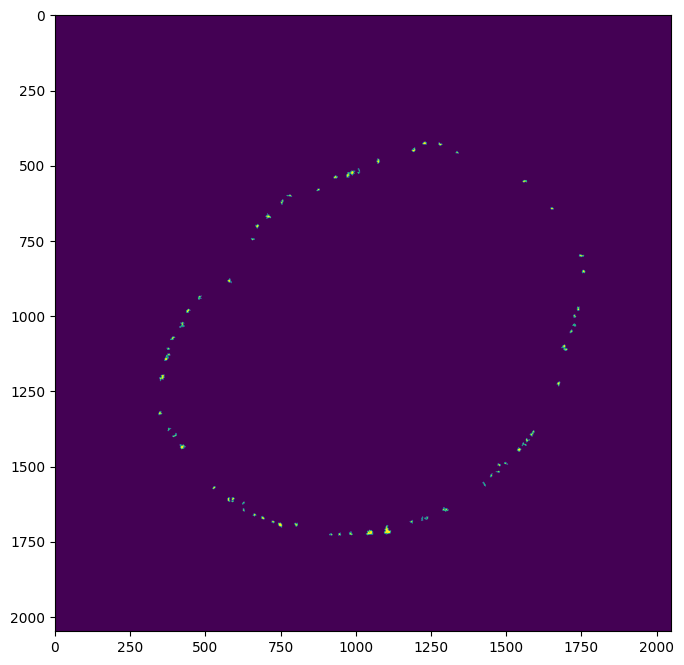

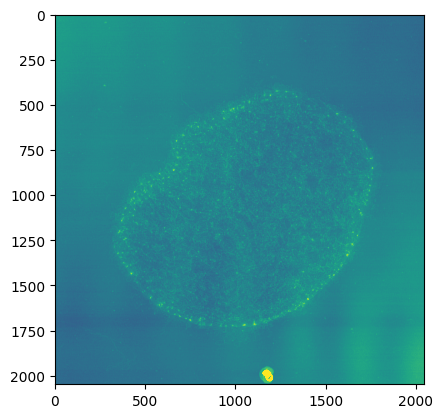

In [27]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
area = shoelace(sorted) * P_TO_MICRON**2
print(f'total object area: {area} μm^2')
perimeter = polygon_perimeter(sorted) * P_TO_MICRON
print(f'perimeter: {perimeter} μm')

# WATERSHED FOR ACCURATE AREA AND VOLUME STATS?

region_statistics = region_stats(labelled_image=labelled, image=flattened)
areas = region_statistics['areas'] * p_to_nm**2
print(f'mean node area: {np.mean(areas)} nm^2')
volumes = region_statistics['volumes'] * p_to_nm**2
print(f'mean node volume: {np.mean(volumes)} nm^3')

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(labelled.astype(bool))
plt.show()
plt.imshow(flattened, vmin=-3, vmax=4)